# A simple demo of the package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sparseRRR_scikit import elastic_rrr, elastic_rrr_bootstrap, elastic_rrr_cv, dimensionality, bibiplot, plot_cv_results 
from sklearn.exceptions import ConvergenceWarning

In [2]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = X.toarray()
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [3]:
data = pickle.load(open('data/scala2020.pickle', 'rb'))

X,Y = preprocess(data)
genes = data['genes'][data['mostVariableGenes']]

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (1213, 1000) 
Shape of Y: (1213, 16)


/var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_4492/4115969558.py:1: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(open('data/scala2020.pickle', 'rb'))


We play with the $\alpha$ parameter, controlling overall regularization strength, in order to select 24 genes as in `demo.ipynb`.

In [4]:
w,v = elastic_rrr(X, Y, rank=2, alpha=.4, l1_ratio=1)

print('\nGenes selected: {}'.format(np.sum(w[:,0]!=0)))
print(', '.join(genes[w[:,0]!=0]))


Genes selected: 24
Arpp21, Bcan, Bdnf, Cacna1e, Cacna2d1, Coro6, Erbb4, Gabrd, Gad1, Galnt14, Htr3a, Kcnip2, Kcnv1, Lamp5, Mybpc1, Npas1, Nxph1, Plch2, Ptk2b, Pvalb, Slc6a1, Sst, Synpr, Tac1


We show that some $l_2$-norms of rows in $\mathbf{W}$ are significant, whilst others are reduced to zero, similarly to what would happen using the glmnet_py package.

Text(0.5, 1.0, 'Sorted row l2-norms of $W$')

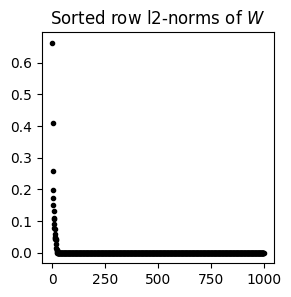

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(np.sort(np.linalg.norm(w, axis=1))[::-1], '.', color='black')
ax.set_title(r'Sorted row l2-norms of $W$')

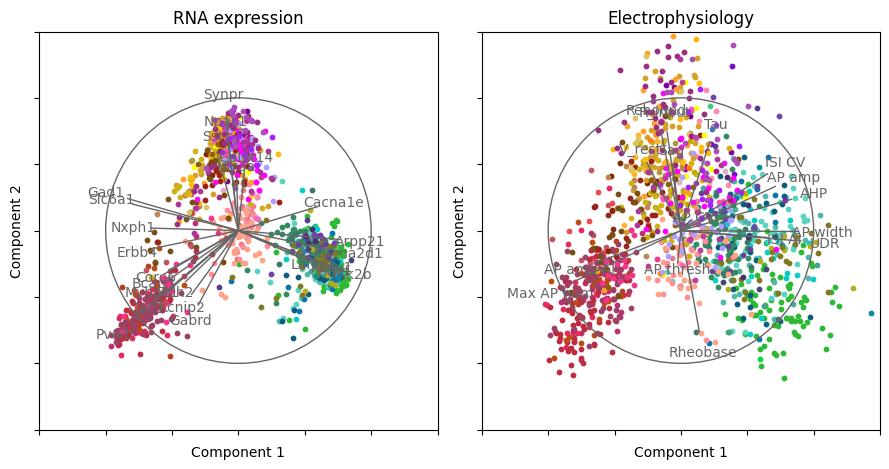

In [6]:
bibiplot(X, Y, w, v, 
         titles = ['RNA expression', 'Electrophysiology'],
         cellTypes = data['ttype'], 
         cellTypeColors = data['colors'], 
         YdimsNames = data['ephysNames'], 
         XdimsNames = genes
         )

In [7]:
alphas = np.concatenate((np.arange(.15,1.01,.1), np.arange(1,6)))
l1_ratios = np.array([.25, .5, .75, 1])

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=(ConvergenceWarning,RuntimeWarning))
    cvResults = elastic_rrr_cv(X, Y, l1_ratios=l1_ratios, alphas=alphas)


1.......... Time: 0.0h  1m 49s


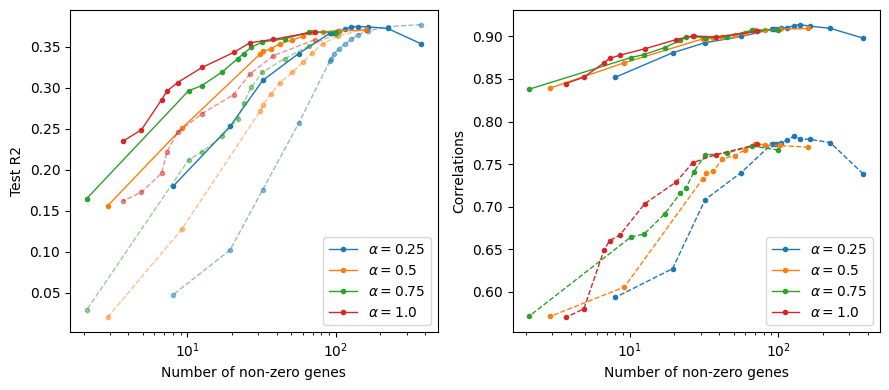

In [8]:
plot_cv_results(*cvResults, l1_ratios)

In [9]:
bootCounts = elastic_rrr_bootstrap(X, Y, alpha=.285, l1_ratio=1)

args = np.argsort(bootCounts)[::-1]
print('')
for i in range(20):
    print('{:10} {:.2f}'.format(genes[args[i]], bootCounts[args[i]]))

.................................................................................................... 

Gad1       1.00
Cacna2d1   1.00
Pvalb      1.00
Lamp5      1.00
Synpr      0.99
Sst        0.99
Plch2      0.99
Slc6a1     0.99
Ptk2b      0.99
Htr3a      0.99
Gabrd      0.99
Tac1       0.98
Cacna1e    0.97
Arpp21     0.96
Erbb4      0.94
Kcnip2     0.92
Coro6      0.92
Galnt14    0.91
Ndn        0.89
Bdnf       0.87


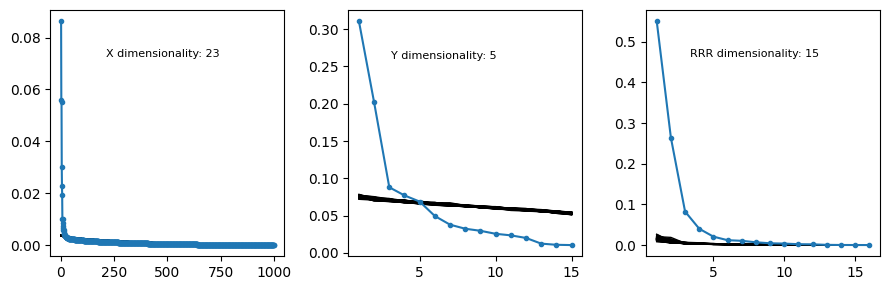

In [10]:
# A quick and dirty way to estimate the dimensionality
dimensionality(X, Y)